In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pypfopt
import yfinance as yf

from portfolio_tools import load_data_for_portfolio, calc_frontier, calc_weights, weights_to_df

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC",  "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%%**********************]  9 of 9 completed


Ticker,AMZN,BAC,COST,DIS,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,
2024-03-21,178.149993896,37.509998322,742.559997559,116.699996948,60.470001221,283.529998779,429.369995117,4.000000000,91.660003662
2024-03-22,178.869995117,37.049999237,734.799987793,115.870002747,60.490001678,282.630004883,428.739990234,3.930000067,90.709999084
2024-03-25,179.710006714,36.860000610,730.960021973,119.360000610,60.400001526,278.619995117,422.859985352,3.910000086,90.669998169
2024-03-26,178.300003052,37.090000153,730.979980469,119.930000305,60.540000916,278.619995117,421.649993896,3.859999895,90.360000610
2024-03-27,179.830001831,37.810001373,732.080017090,120.980003357,61.029998779,282.019989014,421.429992676,3.910000086,91.500000000


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-29    24.763736725
1993-02-01    24.939867020
1993-02-02    24.992702484
1993-02-03    25.256898880
1993-02-04    25.362569809
Name: Adj Close, dtype: float64

In [19]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
   # mcaps[t] = stock.info["marketCap"]
    mcaps[t] = 1
mcaps
mcaps['AMZN'] = 2

In [41]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.725673566861315

In [42]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
AMZN    0.138725541
BAC     0.114664970
COST    0.078658930
DIS     0.106075844
KO      0.070737032
MCD     0.082665249
MSFT    0.093803474
NAT     0.074636463
SBUX    0.087964607
dtype: float64

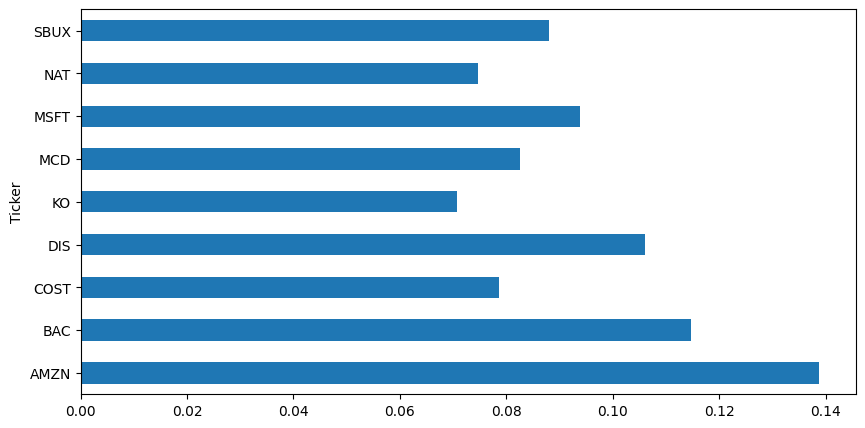

In [22]:
market_prior.plot.barh(figsize=(10,5));

In [23]:
# You don't have to provide views on all the assets
viewdict = {
    #"AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [24]:
confidences = [
#    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [25]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

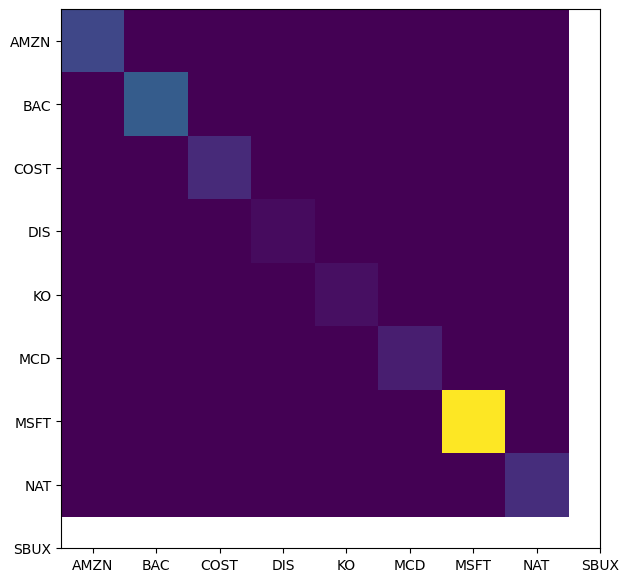

In [26]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [27]:
intervals = [
#    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [28]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


In [29]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [30]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
AMZN    0.134834140
BAC     0.134624155
COST    0.064688995
DIS     0.078855137
KO      0.012172741
MCD     0.108016743
MSFT    0.097006086
NAT     0.074928665
SBUX    0.082473244
dtype: float64

In [31]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.138725541,0.134834140,NaN
BAC,0.114664970,0.134624155,0.30
COST,0.078658930,0.064688995,0.05
DIS,0.106075844,0.078855137,0.05
KO,0.070737032,0.012172741,-0.05
MCD,0.082665249,0.108016743,0.15
MSFT,0.093803474,0.097006086,0.10
NAT,0.074636463,0.074928665,0.50
SBUX,0.087964607,0.082473244,0.10


In [39]:
S_bl = bl.bl_cov()


In [36]:
from pypfopt import EfficientFrontier, objective_functions

In [40]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights
     

D:\Soft\Anaconda\envs\t\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.23218),
             ('BAC', 0.17761),
             ('COST', 0.06305),
             ('DIS', 0.07562),
             ('KO', 0.0),
             ('MCD', 0.15887),
             ('MSFT', 0.16269),
             ('NAT', 0.04785),
             ('SBUX', 0.08213)])

In [41]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc
     

Leftover: $700.55


D:\Soft\Anaconda\envs\t\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'BAC': 109,
 'COST': 2,
 'DIS': 16,
 'KO': 10,
 'MCD': 12,
 'MSFT': 8,
 'NAT': 600,
 'SBUX': 22}

### Crypto

In [18]:
pair = "USDT"
index_assets = pd.read_csv('index_assets.csv')['asset'].tolist()
assets = index_assets
markets = [m + '-' + pair for m in assets]
df_all =  load_data_for_portfolio(markets, '4h')   

AVAX-USDT
BTC-USDT
BNB-USDT
DOT-USDT
DOGE-USDT
ETH-USDT
LINK-USDT
LTC-USDT
LUNA-USDT
MATIC-USDT
MNT-USDT
SOL-USDT
TON-USDT
TRX-USDT
